In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os

### Merge 12 Months of sales data into a single file

In [13]:
files = [file for file in os.listdir('../data/raw')]

all_months_data = pd.DataFrame()

# remove .gitkeep file from files list
files.remove('.gitkeep')

for file in files:
    df = pd.read_csv(f'../data/raw/{file}')
    all_months_data = pd.concat([all_months_data, df])

all_months_data

all_months_data.to_csv('../data/interim/all_data.csv', index=False)

##### Read updated dateframe

In [14]:
all_data = pd.read_csv('../data/interim/all_data.csv')
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


#### Clean up the data

Drop NaN rows

In [17]:
nan_df = all_data[all_data.isna().any(axis=1)]
nan_df.head()
all_data = all_data.dropna(how='all')
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001",12
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001",12
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",12
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",12
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",12


find 'Or' and delete it

In [20]:
all_data = all_data[all_data['Order Date'].str[0:2] != 'Or']
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001",12
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001",12
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",12
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",12
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",12


Convert columns to correct data type for calculations

In [22]:
all_data["Quantity Ordered"] = pd.to_numeric(all_data["Quantity Ordered"])
all_data["Price Each"] = pd.to_numeric(all_data["Price Each"])

### Augment data with additional columns

Add a Month Column

In [21]:
all_data["Month"] = all_data["Order Date"].str[0:2]
all_data["Month"] = all_data["Month"].astype('int32')

Add a Sales column

In [23]:
all_data["Sales"] = all_data["Quantity Ordered"] * all_data["Price Each"]
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales
0,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",12,1700.00
1,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",12,600.00
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",12,11.95
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",12,149.99
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",12,11.95


Add a City Column

In [50]:
def get_city(address):
    return address.split(",")[1]

def get_state(address):
    return address.split(",")[2].split(" ")[1]

city_data = all_data["Purchase Address"].apply(lambda x: f"{get_city(x)} ({get_state(x)})")

all_data["City"] = city_data
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City
0,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",12,1700.00,New York City (NY)
1,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",12,600.00,New York City (NY)
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",12,11.95,New York City (NY)
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",12,149.99,San Francisco (CA)
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",12,11.95,Atlanta (GA)


#### What was the best month for sales? How much was earned that month?

In [41]:
results = all_data.groupby('Month').sum()["Sales"]
results

Month
1     1822256.73
2     2202022.42
3     2807100.38
4     3390670.24
5     3152606.75
6     2577802.26
7     2647775.76
8     2244467.88
9     2097560.13
10    3736726.88
11    3199603.20
12    4613443.34
Name: Sales, dtype: float64

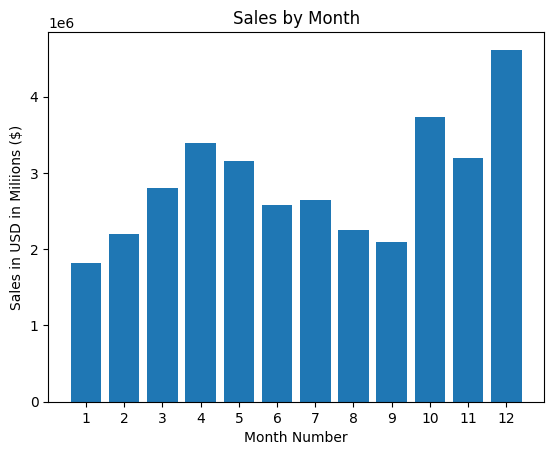

In [49]:
months = range(1, 13)

plt.bar(months, results)
plt.xticks(months)
plt.ylabel('Sales in USD in Miliions ($)')
plt.xlabel("Month Number")
plt.title("Sales by Month")
plt.show()

December has the highest sales at: $4,613,443.34

#### What city had the highest number of sales?

In [53]:
city_results = all_data.groupby('City').sum()["Sales"]
city_results

City
Atlanta (GA)          2795498.58
Austin (TX)           1819581.75
Boston (MA)           3661642.01
Dallas (TX)           2767975.40
Los Angeles (CA)      5452570.80
New York City (NY)    4664317.43
Portland (ME)          449758.27
Portland (OR)         1870732.34
San Francisco (CA)    8262203.91
Seattle (WA)          2747755.48
Name: Sales, dtype: float64

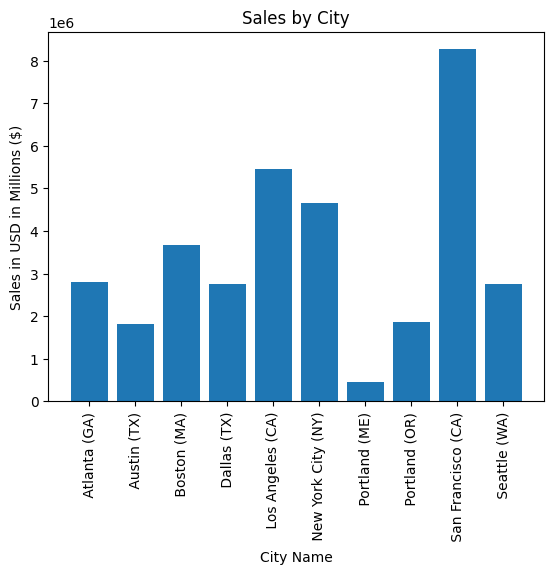

In [54]:
cities = range(1,len(city_results)+1)

plt.bar(city_results.index, city_results)
plt.xticks(city_results.index, rotation='vertical')
plt.ylabel('Sales in USD in Millions ($)')
plt.xlabel("City Name")
plt.title('Sales by City')
plt.show()

San Francisco had the highest number of sales at: $8,262,203.91